# Programming Assingnment4 - Implementation of Transformer Part 2

안녕하세요, **AIKU 학회원 여러분**. 네 번째 과제에서는 지난 주에 작업했던 Transformer Encoder를 바탕으로 Transformer 전체 구조를 완성하고, "Attention is All You Need" 논문에서 다루었던 기계 번역(machine translation) 작업을 수행하게 됩니다. Encoder 부분은 이미 구현되어 있으므로 별도의 구현이 필요하지 않습니다. 지난주에 구현한 **2-4 Encoder Layer**에 이어, 이번 주에는 **2-5 Decoder Layer**부터 구현하시면 됩니다.

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/transformer-model-architecture.png)

## Part 1. 준비

### 1-1. Pip install & Imports
필요한 패키지를 pip를 이용해서 설치합니다.

In [ ]:
!pip install torchdata torchtext spacy portalocker matplotlib seaborn
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

필요한 라이브러리를 import하고, device를 GPU로 바꿔줍니다.

다만, 코드를 구현하는 과정에서는 **CPU 사용**을 권장드립니다.

GPU가 가장 많이 필요한 단계는 학습하는 과정인데 구현하는 시간동안 colab의 GPU를 다 써버리면 막상 학습할 때 필요한 GPU 자원을 쓸 수 없게 됩니다. 따라서 코드를 모두 구현하고 train 코드가 잘 돌아가는지 확인한 뒤에 colab 상단 런타임 메뉴에서 런타임 유형을 GPU로 바꾼 뒤에 실행하면 됩니다.

In [ ]:
# Description: Transformer Model in PyTorch

import os
import random
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader, dataset
from torch.nn.utils.rnn import pad_sequence

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print('using device: ', device)

using device:  cuda


## Part 2. Transformer Architecture

Transformer에 대해서 배우기 전에 기존의 seq2seq를 상기해봅시다. 기존의 seq2seq 모델은 인코더-디코더 구조로 구성되어져 있었습니다. 여기서 인코더는 입력 시퀀스를 하나의 벡터 표현으로 압축하고, 디코더는 이 벡터 표현을 통해서 출력 시퀀스를 만들어냈습니다. 하지만 이러한 구조는 인코더가 입력 시퀀스를 하나의 벡터로 압축하는 과정에서 입력 시퀀스의 정보가 일부 손실된다는 단점이 있었고, 이를 보정하기 위해 어텐션이 사용되었습니다. 그런데 어텐션을 RNN의 보정을 위한 용도로서 사용하는 것이 아니라 어텐션만으로 인코더와 디코더를 만들어보면 어떨까요?

![](https://wikidocs.net/images/page/31379/transformer1.PNG)

Transformer는 RNN을 사용하지 않지만 기존의 seq2seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조를 유지하고 있습니다. 이전 seq2seq 구조에서는 인코더와 디코더에서 각각 하나의 RNN이 t개의 시점(time step)을 가지는 구조였다면 이번에는 인코더와 디코더라는 단위가 N개로 구성되는 구조입니다. Transformer를 제안한 논문에서는 인코더와 디코더의 개수를 각각 6개 사용하였습니다.

![](https://wikidocs.net/images/page/31379/transformer2.PNG)

위의 그림은 인코더와 디코더가 6개씩 존재하는 Transformer의 구조를 보여줍니다. 이 책에서는 인코더와 디코더가 각각 여러 개 쌓여있다는 의미를 사용할 때는 알파벳 s를 뒤에 붙여 encoders, decoders라고 표현하겠습니다.

![](https://wikidocs.net/images/page/31379/transformer4_final_final_final.PNG)

위의 그림은 인코더로부터 정보를 전달받아 디코더가 출력 결과를 만들어내는 트랜스포머 구조를 보여줍니다. 디코더는 마치 기존의 seq2seq 구조처럼 시작 심볼 <sos>를 입력으로 받아 종료 심볼 <eos>가 나올 때까지 연산을 진행합니다. 이는 RNN은 사용되지 않지만 여전히 인코더-디코더의 구조는 유지되고 있음을 보여줍니다.

Transformer의 내부 구조를 조금씩 확대해가는 방식으로 Transformer를 이해해봅시다. 우선 인코더와 디코더의 구조를 이해하기 전에 Transformer의 입력에 대해서 이해해보겠습니다. Transformer의 인코더와 디코더는 단순히 각 단어의 임베딩 벡터들을 입력받는 것이 아니라 임베딩 벡터에서 조정된 값을 입력받는데 이에 대해서 알아보기 위해 입력 부분을 확대해보겠습니다.

## 2-1. Transformer Embedding


Transformer의 내부를 이해하기 전 우선 **Transformer의 입력**에 대해서 알아보겠습니다. RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수 있다는 점에 있었습니다.

하지만 Transformer는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있습니다. Transformer는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 **포지셔널 인코딩(positional encoding)**이라고 합니다.

Positional Encoding은 입력 문장 단어(토큰)들에 대한 위치정보를 인코딩하는 기술로, Transformer 모델의 입력 임베딩에 이 정보를 추가함으로써 단어의 상대적인 위치를 반영할 수 있습니다. 이렇게 함으로써 모델은 문장의 구조와 순서를 학습할 수 있게 됩니다.

다음 코드는 Transformer에서 사용되는 대표적인 Positional Encoding 방법 중 하나인 Sinusodial Positional Encoding입니다. 이 방법은 고정된 함수로서 주기적인 값을 부여하여 위치정보를 인코딩합니다.

Sinusodial Positional Encoding은 다음과 같은 수식을 사용하여 위치 인코딩 값을 계산합니다.

$PE_{(pos,2i)}​ =sin(\frac {pos}{10000^ {2i/d} model​}​ )$

$PE_{(pos,2i+1)}​ =cos(\frac {pos}{10000^ {2i/d} model​}​ )$

여기서 $PE_{(pos, 2i)}$와 $PE_{(pos, 2i+1)}$는 Positional Encoding 행렬에서 $(pos, 2i)$와 $(pos, 2i+1)$ 위치에 해당하는 값을 의미하며, $pos$는 단어의 위치(position)를 나타내고, $i$는 인코딩 차원의 인덱스를 의미합니다. $d_{\text{model}}$은 임베딩 차원의 크기를 나타냅니다.

![](https://wikidocs.net/images/page/31379/transformer7.PNG)

$pos$는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, $i$는 임베딩 벡터 내의 차원의 인덱스를 의미합니다. 위의 식에 따르면 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을 사용하고 홀수인 경우에는 코사인 함수의 값을 사용합니다. 위의 수식에서 $(pos, 2i)$일 때는 사인 함수를 사용하고,  $(pos, 2i+1)$ 일 때는 코사인 함수를 사용하고 있음을 주목합시다.


이렇게 구해진 Positional Encoding 행렬은 입력 임베딩과 더해져서 최종 입력으로 들어가게 되며, 모델은 이를 활용하여 문장의 구조와 순서를 이해하고 학습합니다.


![](https://wikidocs.net/images/page/31379/transformer5_final_final.PNG)

위의 그림은 입력으로 사용되는 임베딩 벡터들이 트랜스포머의 입력으로 사용되기 전에 포지셔널 인코딩의 값이 더해지는 것을 보여줍니다. 임베딩 벡터가 인코더의 입력으로 사용되기 전 포지셔널 인코딩값이 더해지는 과정을 시각화하면 아래와 같습니다.

![](https://wikidocs.net/images/page/31379/transformer6_final.PNG)


In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        embeddings = self.embedding(x)
        embeddings = embeddings.to(x.device)

        return embeddings

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_length, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.create_positional_encoding(max_length, embedding_dim)

    def get_angles(self, max_length, embedding_dim):
        """
        Calculates the angle values for positional encoding in a transformer model.

        This function computes the sinusoidal positional encoding angles based on the specified maximum sequence length and the dimensionality of the embeddings.
        The positional encodings are used to add some information about the relative or absolute position of the tokens in the sequence.
        The formula used here ensures that each dimension of the positional encoding corresponds to a sinusoid of different frequencies and phases.

        Parameters:
        max_length (int): The maximum length of the input sequences for which the positional encodings are to be generated.
        embedding_dim (int): The dimensionality of the embeddings. The number of dimensions should be even as the sinusoids are created for half this dimension size.

        Returns:
        torch.Tensor: A tensor of shape (max_length, embedding_dim // 2) containing the positional encoding angles.
        """

        position = torch.arange(max_length).unsqueeze(1)
        div_term = torch.pow(10000, torch.arange(0, embedding_dim, 2).float() / embedding_dim)

        return position / div_term  # (max_length, embedding_dim / 2)

    def create_positional_encoding(self, max_length, embedding_dim):
        """
        Generates the positional encoding matrix for transformer models.
        This function creates a positional encoding matrix using sinusoidal functions.
        These encodings provide the model with information about the position of the tokens in the sequence.

        Parameters:
        max_length (int): The maximum length of the input sequences for which the positional encodings are to be generated.
        embedding_dim (int): The dimensionality of the embeddings.

        Returns:
        torch.Tensor: A tensor of shape (max_length, embedding_dim) containing the positional encoding matrix. Each row represents the positional encoding of a token in the sequence at different positions.

        Notes:
        The encoding at each position is created by applying the sine function to even indices of the embedding dimensions and the cosine function to the odd indices.
        """

        angles = self.get_angles(max_length, embedding_dim)
        positional_encoding = torch.zeros(max_length, embedding_dim)

        # torch.sin(angles)와 torch.cos(angles)를 차원에 맞게 positional_encoding에 할당
        positional_encoding[:, 0::2] = torch.sin(angles)
        positional_encoding[:, 1::2] = torch.cos(angles)

        return positional_encoding

    def forward(self, x):
        """
        Applies the positional encoding to the input tensor and returns the modified tensor.
        This method adjusts the positional encoding to the device of the input tensor `x` and adds the positional encoding to `x`.
        The positional encoding enhances the model's ability to understand the position of each element in the sequence. The addition of positional encodings to the input is a standard technique used in models like transformers to maintain the order of the input data.

        Parameters:
        x (torch.Tensor): The input tensor to which positional encodings need to be added.

        Returns:
        torch.Tensor: The tensor resulting from adding positional encodings to the input tensor `x`. This output tensor has the same shape as the input tensor.

        Notes:
        The positional encodings are first transferred to the same device as `x` to ensure compatibility in operations.
        Only the required portion of the positional encoding matrix is used, corresponding to the actual sequence length of `x`.
        This portion is detached to prevent gradients from flowing into the positional encoding during backpropagation.
        """
        seq_len = x.size(1)
        positional_encoding = self.positional_encoding.to(x.device)

        return positional_encoding[:x.size(1), :].detach()


제대로 구현했다면 다음과 같은 그래프가 생성되어야 합니다!

![](https://wikidocs.net/images/page/31379/transformer8_final_ver.png)

직접 구현한 PositionalEncoding class로 아래 코드를 이용해서 그래프를 생성해보세요.

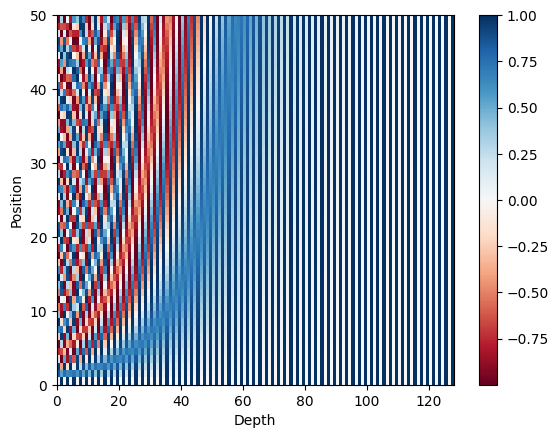

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create an instance of the PositionalEncoding class
max_length = 50
embedding_dim = 128

# Create an instance of the PositionalEncoding class
pos_encoding = PositionalEncoding(max_length, embedding_dim)

# Convert the positional encoding tensor to a numpy array
pos_encoding_matrix = pos_encoding.positional_encoding.detach().numpy()

# Plotting the heatmap of positional encodings
plt.pcolormesh(pos_encoding_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

이제 전체 embedding값을 완성해봅시다

In [ ]:
class TransformerEmbedding(nn.Module):
    """
    Embedding layer for transformer models that combines token embeddings with positional encodings.

    This class implements an embedding layer specific to transformer architectures, combining learned token embeddings with fixed (or learned) positional encodings. The token embeddings convert token indices into embeddings and the positional encodings provide additional context about the position of tokens within the sequence, which is crucial for models without recurrent structure.

    Attributes:
    tok_emb (TokenEmbedding): A module to convert token indices into embeddings.
    pos_emb (PositionalEncoding): A module to generate positional encodings for tokens.

    Parameters:
    vocab_size (int): The size of the vocabulary.
    embedding_dim (int): The dimensionality of the embeddings.
    max_len (int): The maximum length of the input sequences. Note that `max_len` should match the maximum length expected in the positional encoding module.

    Methods:
    forward(x): Computes the embeddings by summing token and positional embeddings.
    """

    def __init__(self, vocab_size, embedding_dim, max_len):

        super(TransformerEmbedding, self).__init__()
        self.tok_emb = TokenEmbedding(vocab_size, embedding_dim)
        self.pos_emb = PositionalEncoding(max_len, embedding_dim)

    def forward(self, x):
        """
        Computes the embeddings for input indices by summing token and positional embeddings.

        Parameters:
        x (torch.Tensor): The input tensor containing token indices.

        Returns:
        torch.Tensor: The tensor containing combined embeddings which are the sum of token and positional embeddings.
        """
        # input x: (batch_size, sequence_length)
        # output: (batch_size, sequence_length, embedding_dim) for encode layer
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)

        return tok_emb + pos_emb

## 2-2. Attention in Transformer


### 2-2-1. Scaled Dot Product Attention

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/scale_dot_product_attention.png)

Self-Attention 메커니즘 중 하나로, 입력 시퀀스 내의 단어들 간의 관계를 학습하는 데 사용되는 기술입니다. 입력 시퀀스의 모든 단어를 서로 다른 관련성 가중치로 가중 평균하여 표현하는 방법입니다.

[계산 방법]

1) 입력 시퀀스를 Query(Q), Key(K), Value(V)로 세 가지 선형 변환을 거칩니다. 이를 통해 각각의 단어들을 차원을 다르게하여 쿼리, 키, 밸류로 표현합니다.

2) 쿼리(Q)와 키(K) 간의 유사도를 계산합니다. 일반적으로는 내적(dot-product)을 사용하여 유사도를 계산합니다.

3) 유사도를 키(K)의 차원 수로 나누어, 스케일링(scaling)을 적용합니다. 스케일링은 유사도를 안정적으로 유지하기 위해 사용됩니다.

4) 계산된 유사도를 소프트맥스(softmax) 함수를 통해 정규화합니다. 이로써 입력 시퀀스 내의 모든 단어들 간의 관련성 가중치를 얻을 수 있습니다.

5) 정규화된 가중치와 키(K)에 대응하는 밸류(V)를 가중 평균하여 Self-Attention 값을 얻습니다. 이는 입력 시퀀스 내의 각 단어에 대해 중요도를 반영한 표현을 얻는 것을 의미합니다.

Scaled Dot-Product Attention은 행렬 연산을 통해 병렬적으로 처리되기 때문에 다수의 단어들 간의 관계를 빠르게 계산할 수 있습니다. 이로 인해 Transformer 모델은 긴 시퀀스에 대해서도 비교적 높은 효율성을 유지할 수 있게 됩니다.

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """
    Implements the scaled dot-product attention mechanism.

    This class provides a scaled dot-product attention mechanism as used in transformer models. It scales the dot products by the square root of the dimension of the attention keys, which helps in stabilizing gradients during backpropagation. Optionally, a mask can be applied to avoid attention to particular positions.

    Attributes:
    embedding_dim (int): The dimensionality of input embeddings.
    attention_dim (int): The dimensionality of the attention space, typically the same as `embedding_dim`.
    scale (torch.Tensor): The scaling factor for the attention scores, computed as the square root of `attention_dim`.

    Parameters:
    embedding_dim (int): Dimensionality of the input embeddings.
    attention_dim (int): Size of the attention keys and values.

    Methods:
    forward(query, key, value, mask=None): Computes the attention values based on the provided query, key, and value tensors. Optional masking can be applied.
    """
    def __init__(self, embedding_dim, attention_dim):
        super(ScaledDotProductAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.attention_dim = attention_dim
        self.scale = torch.sqrt(torch.tensor(attention_dim).float())

    def forward(self, query, key, value, mask=None):
        """
        Computes the attention values using scaled dot-product attention mechanism.

        Parameters:
        query (torch.Tensor): Query tensor of shape (batch_size, num_heads, sequence_length, attention_dim).
        key (torch.Tensor): Key tensor of shape (batch_size, num_heads, sequence_length, attention_dim).
        value (torch.Tensor): Value tensor of shape (batch_size, num_heads, sequence_length, attention_dim).
        mask (torch.Tensor, optional): The mask's elements are 0 where the attention should be masked, and 1 otherwise.

        Returns:
        attention_value (torch.Tensor): The resulting tensor after applying attention, of shape (batch_size, num_heads, sequence_length, attention_dim).

        Notes:
        - The mask is applied to the attention scores before softmax, setting masked positions to a large negative value to minimize their effect in the softmax step.
        """

        key = key.transpose(-2, -1)
        attention_score = torch.matmul(query, key) / self.scale # (batch_size, num_heads, max_length, max_length)
        attention_score = attention_score.masked_fill(mask == 0, -1e10)
        attention_distribution = torch.softmax(attention_score, dim=-1)
        attention_value = torch.matmul(attention_distribution, value) # (batch_size, num_heads, max_length, attention_dim)

        return attention_value

### 2-2-2. MultiHeadAttention


![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/multi_head_attention.png)

마찬가지로 Self-Attention 메커니즘 중 하나로, 입력 시퀀스의 다양한 관점을 캡처하기 위해 여러 개의 Attention 헤드를 병렬로 사용하는 기법입니다. Self-Attention 레이어를 여러 개의 헤드로 나누고, 각 헤드에서 병렬로 Self-Attention을 수행하여 다양한 정보를 효과적으로 추출합니다.

[계산 방법]

1) 입력 시퀀스를 여러 개의 서로 다른 헤드로 분리합니다. 각 헤드는 별도의 Query(Q), Key(K), Value(V) 선형 변환을 적용합니다. 이를 통해 서로 다른 특성을 가진 Query, Key, Value를 추출할 수 있습니다.

2) 각 헤드에서는 Scaled Dot-Product Attention을 사용하여 서로 다른 관점으로 입력 시퀀스의 단어들 간의 관계를 학습합니다. 각 헤드는 서로 다른 관점의 정보를 캡처하고, 다양한 종류의 패턴을 인식할 수 있게 됩니다.

3) 계산된 Self-Attention 결과를 다시 하나의 행렬로 결합합니다. 이를 통해 서로 다른 헤드의 정보를 종합하여 최종 Self-Attention 결과를 얻을 수 있습니다.

4) 병렬로 동작하는 여러 헤드를 가짐으로써, 모델은 다양한 관점에서 입력 시퀀스를 살펴볼 수 있고, 각 단어에 대해 다양한 특징을 추출하여 보다 풍부한 표현을 얻을 수 있게 됩니다.

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Implements the Multi-Head Attention mechanism.

    This class combines multiple attention heads to allow the model to jointly attend to information from different representation subspaces at different positions.
    The input is transformed into multiple heads, each with its own set of linear transformations for queries, keys, and values, followed by the scaled dot-product attention.
    The outputs of these heads are then concatenated and linearly transformed into the final output.

    Attributes:
    num_heads (int): The number of attention heads.
    embedding_dim (int): The total dimension of the input embeddings.
    attention_dim (int): Dimension of each attention head.

    scaled_dot_product_attention (ScaledDotProductAttention): The attention mechanism used in each head.
    Wq (nn.Linear): Linear transformation for query vectors.
    Wk (nn.Linear): Linear transformation for key vectors.
    Wv (nn.Linear): Linear transformation for value vectors.
    Wo (nn.Linear): Linear transformation that combines outputs from all attention heads.

    Parameters:
    embedding_dim (int): Total dimensionality of the input embeddings.
    num_heads (int): Number of heads to split the embedding_dim into.
    """
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention, self,).__init__()
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.attention_dim = self.embedding_dim // self.num_heads

        self.scaled_dot_product_attention = ScaledDotProductAttention(embedding_dim, self.attention_dim)
        self.Wq = nn.Linear(embedding_dim, self.attention_dim * num_heads)
        self.Wk = nn.Linear(embedding_dim, self.attention_dim * num_heads)
        self.Wv = nn.Linear(embedding_dim, self.attention_dim * num_heads)
        self.Wo = nn.Linear(self.attention_dim * num_heads, embedding_dim)

    def forward(self, query, key, value, mask=None):
        """
        Computes the output of the Multi-Head Attention layer.

        Parameters:
        query (torch.Tensor): Query tensor of shape (batch_size, sequence_length, embedding_dim).
        key (torch.Tensor): Key tensor of shape (batch_size, sequence_length, embedding_dim).
        value (torch.Tensor): Value tensor of shape (batch_size, sequence_length, embedding_dim).
        mask (torch.Tensor, optional): Mask tensor (batch_size, 1, sequence_length, sequence_length) to exclude certain positions from attention.

        Returns:
        torch.Tensor: The resulting tensor after applying multi-head attention, of shape (batch_size, sequence_length, embedding_dim).
        """
        batch_size = query.size(0)
        sequence_length = query.size(1)

        query = self.Wq(query).reshape(batch_size, sequence_length, self.num_heads, self.attention_dim).transpose(1, 2)
        key = self.Wk(key).reshape(batch_size, sequence_length, self.num_heads, self.attention_dim).transpose(1, 2)
        value = self.Wv(value).reshape(batch_size, sequence_length, self.num_heads, self.attention_dim).transpose(1, 2)

        attention_values = self.scaled_dot_product_attention(query, key, value, mask)   # (batch_size, num_heads, max_length, attention_dim)
        attention_values = attention_values.transpose(1, 2).reshape(batch_size, sequence_length, self.num_heads * self.attention_dim)
        output = self.Wo(attention_values)

        return output

## 2-3. FeedForwardNeuralNetwork

가장 간단한 형태의 FeedForward Network의 형태로 설명을 읽고 순서에 맞추어 구현해주시면 되겠습니다.
![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/feed-forward.png)

Position-wise Feed-Forward Network은 각 위치(position)별로 독립적으로 적용되는 두 개의 선형 변환과 활성화 함수로 구성되는 네트워크입니다. 모델의 비선형성을 증가시키고, 입력 시퀀스의 각 위치에서 다양한 특징을 추출하는 데 도움이 됩니다.

[설명]

1) 입력 시퀀스의 각 위치별로, 먼저 하나의 선형 변환을 적용합니다. 이는 입력 시퀀스의 각 위치별로 입력 차원을 다른 차원으로 매핑하는 역할을 합니다.

2) 활성화 함수로 주로 ReLU(Rectified Linear Unit)가 사용됩니다. 이 활성화 함수는 비선형성을 도입하여 모델이 더 복잡한 관계를 학습할 수 있도록 도와줍니다.

3) 두 번째 선형 변환을 적용합니다. 이는 ReLU 활성화 함수를 통과한 결과를 다시 다른 차원으로 매핑하여 최종적인 출력 차원을 얻는 역할을 합니다.

- PoswiseFeedForwardNet은 다음과 같은 수식으로 표현될 수 있습니다:

- $PoswiseFeedForwardNet(x)=ReLU(xW_1​ +b_1​)W_2​ +b_2
​ $

여기서
$x$는 입력 시퀀스의 각 위치에 대한 벡터를 나타내고, $W_1$과 $b_1$은 첫 번째 선형 변환의 가중치 행렬과 편향 벡터, $W_2$와 $b_2$는 두 번째 선형 변환의 가중치 행렬과 편향 벡터를 나타냅니다.

모델이 입력 시퀀스의 각 위치에서 다양한 특징을 추출하고, 비선형성을 도입하여 더 풍부한 표현을 학습할 수 있도록 합니다.

In [ ]:
class FeedForwardNeuralNetwork(nn.Module):
    """
    Implements a simple feed-forward neural network with one hidden layer as part of a transformer model.

    This class defines a two-layer feed-forward neural network often used as the position-wise feed-forward network in transformer models. It includes a ReLU activation between the two linear layers, which allows the network to introduce non-linearity into the model's architecture, enhancing its learning capabilities.

    Attributes:
    W1 (nn.Linear): First linear transformation layer mapping from `embedding_dim` to `feed_forward_dim`.
    W2 (nn.Linear): Second linear transformation layer mapping from `feed_forward_dim` back to `embedding_dim`.
    relu (nn.ReLU): The ReLU activation function applied after the first linear transformation.

    Parameters:
    embedding_dim (int): Dimensionality of input and output embeddings.
    feed_forward_dim (int): Dimensionality of the hidden layer.

    Methods:
    forward(inputs): Processes the input through the two linear layers and ReLU activation, producing the transformed output.
    """
    def __init__(self, embedding_dim, feed_forward_dim, drop_prob):
        super(FeedForwardNeuralNetwork, self).__init__()
        self.W1 = nn.Linear(embedding_dim, feed_forward_dim)
        self.W2 = nn.Linear(feed_forward_dim, embedding_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, inputs):
        """
        Computes the output of the feed-forward neural network.

        Parameters:
        inputs (torch.Tensor): The input tensor of shape (batch_size, sequence_length, embedding_dim).

        Returns:
        torch.Tensor: The output tensor after processing through the feed-forward neural network, matching the shape of the input tensor (batch_size, sequence_length, embedding_dim).
        """
        outputs = self.W1(inputs)
        outputs = self.relu(outputs)
        outputs = self.dropout(outputs)
        outputs = self.W2(outputs)

        return outputs

In [ ]:
class LayerNormalization(nn.Module):
    def __init__(self, num_features):
        super(LayerNormalization, self).__init__()
        self.layer_norm = nn.LayerNorm(num_features)

    def forward(self, x):
        x = self.layer_norm(x)
        return x

In [ ]:
def create_padding_mask_for_attention(batch: Tensor, pad_idx: int) -> Tensor:
    """
    Creates a square binary padding mask for the attention mechanism, where the mask indicates
    whether each token in the input batch is a padding token or not. This mask can be used
    in attention mechanisms to prevent attention to padding tokens.

    This function assumes that the input tensor `batch` is a 2D tensor representing sequences of
    tokens, where each element in the tensor is a token ID. The mask is constructed such that
    it has dimensions suitable for multi-head attention, adding two additional dimensions
    to cater to the heads and to square the mask.

    Parameters:
    - batch (Tensor): A 2D tensor of shape (batch_size, sequence_length), where each entry is a token ID.
    - pad_idx (int): The token ID used to identify padding tokens in the batch.

    Returns:
    - Tensor: A 4D binary mask tensor of shape (batch_size, 1, sequence_length, sequence_length).
              This tensor is placed on the same device as the input tensor `batch`.
              A value of `True` at a position indicates that the corresponding token
              is not a padding token and should be attended to, while `False` indicates
              it is a padding token and should not be attended to in the attention layers.

    """
    padding_mask = (batch != pad_idx)
    sequence_length = batch.size(1)
    padding_mask = padding_mask.unsqueeze(1).repeat(1, sequence_length, 1)
    padding_mask = padding_mask.unsqueeze(1)

    return padding_mask.to(device) # (batch_size, 1, max_length, max_length)

### 2-4. Encoder
**Encoder Layer를 직접 구현해봅니다!**

앞 서 구현한 클래스를 바탕으로 Encoder Layer의 순서에 맞게 Encoder Layer를 구현해주시면 됩니다. 아래 이미지와 강의자료를 참고해주세요!

Encoder Layer는 입력 시퀀스의 단어들을 인코딩하여 중간 표현을 생성하는 역할을 합니다.

1) 입력 단어들에 대해 주변 단어들과의 관련성을 고려한 Self-Attention을 수행하여 풍부한 문맥 정보를 추출합니다.

2) Feed-Forward Network를 통해 비선형성을 도입하고 다양한 특징을 추출합니다.

3) Layer 간 잔차 연결과 Layer Normalization으로 Gradient Vanishing 문제를 완화하고, 모델 학습을 돕습니다.

![](https://raw.githubusercontent.com/paul-hyun/paul-hyun.github.io/master/assets/2019-12-19/encoder.png)


In [ ]:
class EncoderLayer(nn.Module):
    """
    Represents a single layer of a Transformer encoder as described in the paper "Attention is All You Need".
    This layer includes two sub-layers: a multi-head self-attention mechanism, and a position-wise fully connected feed-forward network.
    Each of these sub-layers has a residual connection around it followed by layer normalization.

    Attributes:
        multi_head_attention (MultiHeadAttention): The multi-head attention component which performs self-attention over the input batch.
        feed_forward_neural_network (FeedForwardNeuralNetwork): The feed-forward neural network that transforms the output of the attention mechanism.
        norm1 (LayerNormalization): The first layer normalization that is applied after the attention mechanism and before the addition of the residual connection.
        norm2 (LayerNormalization): The second layer normalization that is applied after the feed-forward network and before the addition of the residual connection.

    Parameters:
        embedding_dim (int): The dimensionality of the input embeddings.
        feed_forward_dim (int): The dimensionality of the hidden layer in the feed-forward neural network.
        num_heads (int): The number of heads in the multi-head attention mechanism.

    Methods:
        forward(batch: Tensor, padding_mask: Tensor) -> Tensor:
            Processes the input `batch` through one encoder layer including multi-head attention,
            layer normalization, and a feed-forward network to produce an output tensor.

            Parameters:
                batch (Tensor): The input tensor to the encoder layer with shape
                    (batch_size, sequence_length, embedding_dim).
                padding_mask (Tensor): The padding mask tensor with shape
                    (batch_size, 1, sequence_length, sequence_length), used in the multi-head attention to avoid
                    attending to padding positions.

            Returns:
                Tensor: The output of the encoder layer, which has the same shape as the input
                    batch (batch_size, sequence_length, embedding_dim).

    """
    def __init__(self, embedding_dim, feed_forward_dim, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(embedding_dim, num_heads)
        self.norm1 = LayerNormalization(embedding_dim)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.feed_forward_neural_network = FeedForwardNeuralNetwork(embedding_dim, feed_forward_dim, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(embedding_dim)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, padding_mask):
        _x = x
        x = self.multi_head_attention(x, x, x, padding_mask)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        _x = x
        x = self.feed_forward_neural_network(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)

        return x


**Encoder Layer를 구현했다면 전체 Transformer Encoder의 구조를 구현해봅시다.**

해당 Encoder가 전체 input부터 output까지 출력하는 전체 구조입니다. 역시나 앞 서 구현한 클래스들을 바탕으로 구현해주시면 되고 Transformer Encoder에는 Encoder Layer(Block)이 여러 개(논문 기준 6개)가 포함된다고 설명드렸습니다. 이 점에 유의해서 구현해주세요!

1) 입력에 대한 Position 값을 구하기: 각 단어의 상대적인 위치를 나타내는 Positional Encoding을 계산합니다.

2) Input Embedding과 Position Embedding 더하기: 입력 시퀀스의 단어들을 임베딩하여 벡터로 표현한 후, Positional Encoding을 더합니다. 이를 통해 입력 시퀀스의 단어들은 고유한 위치 정보를 가진 임베딩으로 변환됩니다.

3) 입력에 대한 Attention Pad Mask 구하기: Self-Attention 레이어에서 패딩 부분에 대한 마스크를 생성합니다. 이렇게 함으로써 모델이 패딩 부분을 무시하고, 실제 입력에만 집중할 수 있도록 돕습니다.

4) for 루프를 돌며 각 layer를 실행하기: 여러 개의 EncoderLayer로 구성된 스택을 순차적으로 거칩니다. 각 EncoderLayer는 입력 시퀀스에 대한 인코딩을 수행하고, 다음 EncoderLayer로 전달하기 위해 중간 결과를 출력합니다.

5) layer의 입력은 이전 layer의 출력 값: 스택의 첫 번째 EncoderLayer를 거칠 때는 이전 layer가 없으므로, Input Embedding과 Position Embedding의 결과가 첫 번째 EncoderLayer의 입력으로 사용됩니다. 이후의 EncoderLayer들은 이전 layer의 출력 값을 입력으로 받아 처리합니다.

이렇게 입력 시퀀스에 대한 인코딩을 위해 Positional Encoding, Self-Attention, Residual Connection 등의 기법을 사용하여 입력 정보를 풍부하게 표현합니다. 이 과정을 여러 번 쌓아 올려서 Encoder를 형성하며, 최종적으로 입력 시퀀스의 문맥 정보를 잘 반영한 중간 표현을 얻습니다.

In [ ]:
class Encoder(nn.Module):
    """
    A Transformer encoder module for processing sequences using multiple encoder layers.

    This class is a PyTorch module that utilizes a stack of transformer encoder layers to process
    input sequences. It first applies positional embeddings using a TransformerEmbedding layer
    before passing the data through multiple transformer encoder layers.

    Attributes:
        transformer_embedding (TransformerEmbedding): An embedding layer that adds position
            embeddings to the token embeddings.
        encoder_layers (nn.ModuleList): A list of encoder layers (instances of EncoderLayer)
            used to process the input data sequentially.

    Args:
        vocab_size (int): The size of the vocabulary (number of unique tokens).
        sequence_length (int): The sequence length of input sequences.
        embedding_dim (int): The dimensionality of token embeddings.
        feed_forward_dim (int): The dimensionality of the feed-forward networks in the encoder layers.
        num_heads (int): The number of attention heads in each encoder layer.
        num_layers (int): The number of encoder layers in the module.

    Methods:
        forward(x, padding_mask):
            Processes input data through the transformer embedding and each encoder layer sequentially.

            Args:
                x (Tensor): The input tensor containing token indices, shape [batch_size, sequence_length].
                padding_mask (Tensor): The padding mask for the input tensor, shape [batch_size, sequence_length].

            Returns:
                Tensor: The output tensor from the final encoder layer, shape [batch_size, sequence_length, embedding_dim].
    """
    def __init__(self, vocab_size, sequence_length, embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob):
        super(Encoder, self).__init__()
        self.transformer_embedding = TransformerEmbedding(vocab_size, embedding_dim, sequence_length)
        self.encoder_layers = nn.ModuleList([EncoderLayer(embedding_dim, feed_forward_dim, num_heads, drop_prob)
                                             for _ in range(num_layers)])

    def forward(self, x, padding_mask):
        x = self.transformer_embedding(x)

        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, padding_mask)

        return x



---


# **여기서부터 구현 시작하시면 됩니다!!**

## 2-5. Decoder


![](https://wikidocs.net/images/page/31379/decoder.PNG)


### 2-5-1. Look-Ahead Mask

위 그림과 같이 decoder도 encoder와 동일하게 embedding layer와 positional encoding 을 거친 후의 문장 행렬이 입력됩니다. Transformer 또한 seq2seq와 마찬가지로 교사 강요(Teacher Forcing)을 사용하여 훈련되므로 학습 과정에서 decoder는 번역할 문장에 해당되는 `<sos> je suis étudiant`의 문장 행렬을 한 번에 입력받습니다. 그리고 decoder는 이 문장 행렬로부터 각 시점의 단어를 예측하도록 훈련됩니다.

여기서 문제가 있습니다. seq2seq의 decoder에 사용되는 RNN 계열의 신경망은 입력 단어를 매 시점마다 순차적으로 입력받으므로 다음 단어 예측에 현재 시점을 포함한 이전 시점에 입력된 단어들만 참고할 수 있습니다. 반면, Transformer는 문장 행렬로 입력을 한 번에 받으므로 현재 시점의 단어를 예측하고자 할 때, 입력 문장 행렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상이 발생합니다. 가령, suis를 예측해야 하는 시점이라고 해봅시다. RNN 계열의 seq2seq의 decoder라면 현재까지 decoder에 입력된 단어는 <sos>와 je뿐일 것입니다. 반면, Transformer는 이미 문장 행렬로 `<sos> je suis étudiant`를 입력받았습니다.

이를 위해 Transformer의 decoder에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 룩-어헤드 마스크(look-ahead mask)를 도입했습니다. 직역하면 '미리보기에 대한 마스크'입니다.

룩-어헤드 마스크(look-ahead mask)는 decoder의 첫번째 sublayer에서 이루어집니다. Decoder의 첫번째 sublayer인 multi-head self-attention layer는 encoder의 첫번째 sublayer인 multi-head self-attention layer와 동일한 연산을 수행합니다. 오직 다른 점은 attention score 행렬에서 masking을 적용한다는 점만 다릅니다. 우선 다음과 같이 self-attention을 통해 attention score 행렬을 얻습니다.

![](https://wikidocs.net/images/page/31379/decoder_attention_score_matrix.PNG)


이제 자기 자신보다 미래에 있는 단어들은 참고하지 못하도록 다음과 같이 masking합니다.

![](https://wikidocs.net/images/page/31379/%EB%A3%A9%EC%96%B4%ED%97%A4%EB%93%9C%EB%A7%88%EC%8A%A4%ED%81%AC.PNG)

Masking 된 후의 attention score 행렬의 각 행을 보면 자기 자신과 그 이전 단어들만을 참고할 수 있음을 볼 수 있습니다. 그 외에는 근본적으로 self-attention이라는 점과, multi-head attention을 수행한다는 점에서 encoder의 첫번째 sublayer와 같습니다.

Look-ahead mask의 구현에 대해 알아봅시다. Look-ahead mask는 padding mask와 마찬가지로 앞서 구현한 scaled dot product attention 함수에 mask라는 인자로 전달됩니다. Padding mask를 써야하는 경우에는 scaled dot product attention 함수에 padding mask를 전달하고, look-ahead mask를 써야하는 경우에는 scaled dot product attention 함수에 look-ahead mask를 전달합니다.

이때 look-ahead mask를 한다고해서 padding mask가 불필요한 것이 아니므로 look-ahead mask는 padding mask를 포함하도록 구현합니다. Look-ahead mask를 구현하는 방법은 padding mask 때와 마찬가지로 masking을 하고자 하는 위치에는 0을, masking을 하지 않는 위치에는 1을 리턴하도록 합니다.

In [ ]:
def create_look_ahead_mask_for_attention(tgt_batch: torch.Tensor, pad_idx: int) -> torch.Tensor:
    """
    Creates a look-ahead mask to prevent positions from attending to future positions in the
    target sequence during self-attention computations in the Transformer decoder. This mask is combined
    with a padding mask to ensure that padding positions are also ignored.

    Parameters:
    - tgt_batch (Tensor): A tensor of shape (batch_size, tgt_length) containing target
      sequences where each element is a token index.
    - pad_idx (int): The index used for padding tokens within the batch.

    Returns:
    - Tensor: A combined look-ahead and padding mask tensor of shape
      (batch_size, 1, tgt_length, tgt_length). This tensor contains Boolean values, where `True`
      indicates that attention is allowed and `False` indicates it is blocked.

    Example:
    ```python
    import torch

    # Assuming the presence of 'create_look_ahead_mask_for_attention' in the current script or imported module
    # and 'pad_idx' is known (e.g., if pad_idx is 0)

    # Example tensor simulating a batch of target sequences with batch_size=2 and tgt_length=3
    # Assume padding index (pad_idx) is 0, and the actual data does not include this index in this example
    tgt_batch = torch.tensor([[1, 2, 3], [4, 5, 6]])

    # Generate the look-ahead mask
    mask = create_look_ahead_mask_for_attention(tgt_batch, pad_idx=0)

    # Print the mask output, showing blocked future positions and allowing current and past positions
    print(mask)
    # Output:
    # tensor([[[[ True, False, False],
    #           [ True,  True, False],
    #           [ True,  True,  True]]],
    #
    #         [[[ True, False, False],
    #           [ True,  True, False],
    #           [ True,  True,  True]]]], dtype=torch.bool)
    ```

    Notes:
    - Ensure that `tgt_batch` is on the same device as the `device` variable defined in the function's scope or
      configure the function to automatically detect the device from `tgt_batch`.
    - This function handles both the triangular look-ahead masking and the padding by combining them into a single mask.
    """

    batch_size, tgt_length = tgt_batch.size()

    # look-ahead mask 구현
    tgt_attention_mask = torch.tril(torch.ones((tgt_length, tgt_length), dtype=torch.bool, device=tgt_batch.device))
    tgt_attention_mask = tgt_attention_mask.unsqueeze(0).unsqueeze(1)
    tgt_attention_mask = tgt_attention_mask.repeat(batch_size, 1, 1, 1)

    tgt_padding_mask = create_padding_mask_for_attention(tgt_batch, pad_idx) # (batch_size, 1, max_length, max_length)
    tgt_attention_mask = tgt_attention_mask.to(torch.int) & tgt_padding_mask.to(torch.int)

    return tgt_attention_mask

### 2-5-2. Decoder Layer

**Decoder Layer를 직접 구현해봅니다!**

이제 Encoder Layer를 통해 변환된 정보를 사용하여 Decoder Layer를 구현해보겠습니다. 아래 내용과 강의자료를 참고하시어 Decoder를 구현하시면 됩니다.

Decoder는 encoder에서 변환된 정보를 바탕으로 sequence를 생성하는 과정에서 중요한 역할을 합니다.

1. 입력된 sequence와 Encoder에서 전달된 출력을 이용해 Masked Self-Attention을 수행합니다. 이 과정에서 미래 시점의 정보가 예측에 영향을 주지 않도록 masking 처리를 하여 현재 및 이전 단어들만 고려됩니다.

2. Encoder-Decoder Attention에서는 Decoder의 출력을 query로 하고, Encoder의 출력을 key와 value로 사용합니다. 이는 Decoder가 Encoder로부터 전달된 output을 통해 필요한 정보를 선택적으로 추출할 수 있게 합니다.

3. Masked Self-Attention과 Encoder-Decoder Attention 후에는 추가적인 Feed-Forward Network를 통해 출력 sequence의 각 단어에 대한 최종 예측을 생성하기 전에 nonlinear transformation을 적용합니다.

4. 각 단계마다 residual connection과 layer normalization을 사용하여 모델의 학습 안정성을 증진시키고, Gradient Vanishing 문제를 방지합니다.

Decoder Layer는 이러한 단계들을 통해 입력 sequence에 따른 결과 sequence를 적절히 생성하며, 최종적으로 원하는 타겟 sequence를 생성하는 데 중요한 역할을 합니다.

![](https://wikidocs.net/images/page/31379/decoder.PNG)

In [ ]:
class DecoderLayer(nn.Module):
    """
    Implements a single layer of a Transformer decoder as described in "Attention is All You Need" paper.

    This layer includes three main components: masked multi-head self-attention, encoder-decoder attention,
    and a position-wise feed-forward neural network. Each of these components is followed by layer normalization
    and dropout for regularization.

    Attributes:
        masked_multi_head_attention (MultiHeadAttention): The multi-head attention mechanism with masking,
            used for self-attention within the decoder.
        norm1 (LayerNormalization): Normalization layer following the masked multi-head attention.
        dropout1 (nn.Dropout): Dropout layer after the first normalization layer.

        enc_dec_attention (MultiHeadAttention): Multi-head attention mechanism used between the encoder
            and decoder to focus on relevant parts of the input sequence.
        norm2 (LayerNormalization): Normalization layer following the encoder-decoder attention.
        dropout2 (nn.Dropout): Dropout layer after the second normalization layer.

        feed_forward_neural_network (FeedForwardNeuralNetwork): Position-wise feed-forward neural network,
            applies a fully connected layer to each position separately and identically.
        norm3 (LayerNormalization): Normalization layer following the feed-forward neural network.
        dropout3 (nn.Dropout): Dropout layer after the third normalization layer.

    Parameters:
        embedding_dim (int): Dimensionality of the input token embeddings.
        feed_forward_dim (int): Dimensionality of the inner layer of the feed-forward neural network.
        num_heads (int): Number of attention heads.
        drop_prob (float): Dropout probability.

    Methods:
        forward(dec, enc, src_mask, trg_mask): Defines the computation performed at every call. It processes
            the input through the decoder layer transformations and returns the transformed output.

        Parameters for forward:
            dec (Tensor): The sequence of embeddings representing the decoder's input. (batch_size, sequence_length, embedding_dim)
            enc (Tensor): The sequence of embeddings from the encoder's output. (batch_size, sequence_length, embedding_dim)
            src_mask (Tensor): The mask applied to the encoder's output. (batch_size, 1, sequence_length, sequence_length)
            trg_mask (Tensor): The mask applied to the decoder's input to prevent attending to future tokens. (batch_size, 1, sequence_length, sequence_length)
    """

    # DecoderLayer 구현

    def __init__(self, embedding_dim, feed_forward_dim, num_heads, drop_prob):
      super(DecoderLayer, self).__init__()
      self.masked_multi_head_attention = MultiHeadAttention(embedding_dim, num_heads)
      self.norm1 = LayerNormalization(embedding_dim)
      self.dropout1 = nn.Dropout(p=drop_prob)

      self.enc_dec_attention = MultiHeadAttention(embedding_dim, num_heads)
      self.norm2 = LayerNormalization(embedding_dim)
      self.dropout2 = nn.Dropout(p=drop_prob)

      self.feed_forward_neural_network = FeedForwardNeuralNetwork(embedding_dim, feed_forward_dim, drop_prob=drop_prob)
      self.norm3 = LayerNormalization(embedding_dim)
      self.dropout3 = nn.Dropout(p=drop_prob)


    def forward(self, dec, enc, src_mask, trg_mask):
      input_dec = dec
      dec = self.masked_multi_head_attention(dec, dec, dec, trg_mask)
      dec = self.dropout1(dec)
      dec += input_dec
      dec = self.norm1(dec)

      self_dec = dec
      dec = self.enc_dec_attention(dec, enc, enc, src_mask)
      dec = self.dropout2(dec)
      dec += self_dec
      dec = self.norm2(dec)

      attention_dec = dec
      dec = self.feed_forward_neural_network(dec)
      dec = self.dropout3(dec)
      dec += attention_dec
      dec = self.norm3(dec)

      return dec.to(dec.device)

**Decoder Layer를 구현했다면 전체 Transformer Decoder의 구조를 구현해봅시다.**

해당 Decoder는 Encoder로부터의 출력과 함께 타겟 sequecne를 입력받아 최종 출력 sequence를 생성합니다. Decoder 역시 여러 개의 Decoder Layer(Block)로 구성되어 있습니다 (논문 기준 6개). 각 단계를 철저히 이해하고 구현해 주세요.

1.  타겟 입력에 대한 Position 값을 구하기: 타겟 입력 sequence의 각 단어에 대해 Positional Encoding을 계산합니다.

2. Target Embedding과 Position Embedding 더하기: 타겟 sequence의 단어들을 embedding하여 벡터로 표현한 후, 해당 Positional Encoding을 더합니다. 이렇게 함으로써 각 단어는 위치 정보가 포함된 embedding으로 변환됩니다.

3. 입력에 대한 Masked Attention Pad Mask 구하기: Decoder의 첫 번째 Self-Attention layer에서는 자신보다 뒤에 오는 단어들을 참조하지 않도록 masking 처리를 합니다. 이는 타겟 sequence의 예측 중 미래의 정보를 참조하는 것을 방지하기 위함입니다.

4. Encoder-Decoder Attention을 통해 Encoder의 출력과 결합: 각 DecoderLayer는 Encoder의 출력을 사용하여 Encoder-Decoder Attention를 실행합니다. 이 과정에서 Decoder는 Encoder로부터 필요한 정보를 효율적으로 추출하여 타겟 sequence의 생성을 최적화합니다.

5. layer의 입력은 이전 layer의 출력 값: 스택의 첫 번째 DecoderLayer를 거칠 때는 이전 layer가 없으므로, Target Embedding과 Position Embedding의 결과가 첫 번째 DecoderLayer의 입력으로 사용됩니다. 이후의 DecoderLayer들은 이전 layer의 출력 값을 입력으로 받아 처리합니다.

6. for 루프를 돌며 각 layer를 실행하기: 여러 개의 DecoderLayer로 구성된 스택을 순차적으로 거칩니다. 각 DecoderLayer는 타겟 입력 sequence를 기반으로 연산을 수행하고, 다음 DecoderLayer로 중간 결과를 전달합니다.

Decoder는 이러한 과정을 거쳐 최종적으로 각 타겟 sequence의 단어를 예측하는 데 필요한 정보를 통합하고, 전체 sequence를 생성하는 중요한 역할을 수행합니다.

In [ ]:
class Decoder(nn.Module):
    """
    Implements the decoder part of a Transformer model, which processes the encoded input
    and generates an output sequence. The decoder is composed of multiple layers of a custom
    `DecoderLayer`, a transformer embedding layer at the input, and a final dense layer that
    outputs the probability distribution over a vocabulary.

    Attributes:
        transformer_embedding (TransformerEmbedding): Embedding layer for input tokens that
            also adds positional encodings.
        decoder_layers (nn.ModuleList): A list of `DecoderLayer` instances, each of which applies
            masked multi-head attention, encoder-decoder attention, and a feed-forward network.
        dense_layer (nn.Linear): A linear transformation applied to the outputs of the decoder layers,
            mapping them to the vocabulary size.

    Parameters:
        vocab_size (int): The size of the vocabulary.
        sequence_length (int): The maximum length of input sequences.
        embedding_dim (int): The dimensionality of the embedding space.
        feed_forward_dim (int): The dimensionality of the inner layer of the feed-forward neural network in the decoder.
        num_heads (int): The number of heads in the multi-head attention mechanisms.
        num_layers (int): The number of `DecoderLayer` modules in the decoder.
        drop_prob (float): The dropout probability used in dropout layers within the decoder layers.

    Methods:
        forward(dec, enc, src_mask, trg_mask): Defines the computation performed at every call.
            It processes the decoder input through the embedding layer, all the decoder layers in sequence,
            and then through the dense layer to produce the final output logits.

        Parameters for forward:
            dec (Tensor): The sequence of input tokens (indices) for the decoder.
            enc (Tensor): The sequence of embeddings output by the encoder, which acts as context for the decoder.
            src_mask (Tensor): The mask to be applied to the encoder outputs to prevent attention to certain positions.
            trg_mask (Tensor): The mask applied to the decoder inputs to prevent attention to subsequent positions
                               in the sequence (used to enforce causality in the decoder).
    """

    # Decoder 구현
    def __init__(self, vocab_size, sequence_length, embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob):
      super(Decoder, self).__init__()
      # input: (batch_size, sequence_length) output: (batch_size, sequence_length, embedding_dim) for encode layer
      self.transformer_embedding = TransformerEmbedding(vocab_size, embedding_dim, sequence_length)
      self.decoder_layers = nn.ModuleList([DecoderLayer(embedding_dim, feed_forward_dim, num_heads, drop_prob) for _ in range(num_layers)])
      self.dense_layer = nn.Linear(embedding_dim, vocab_size)


    def forward(self, dec, enc, src_mask, trg_mask):
      dec = self.transformer_embedding(dec)
      # enc = self.transformer_embedding(enc) 이미 encoder를 거쳐온 것임

      for decoder_layer in self.decoder_layers:
        dec = decoder_layer(dec, enc, src_mask, trg_mask)

      dec = self.dense_layer(dec)
      #dec = torch.softmax(dec, dim = -1)
      # output: (batch_size, max_length, vocab_size)
      return dec

### 2-6. Transformer 완성


![](https://wikidocs.net/images/page/31379/transformer_attention_overview.PNG)


In [ ]:
class Transformer(nn.Module):
    """
    Implements a Transformer model which consists of an encoder and a decoder.
    The Transformer model is designed to handle sequences of tokens from two languages (source and target),
    translating from the source language to the target language. This class is suitable for tasks such as
    machine translation.

    Attributes:
        encoder (Encoder): The Encoder part of the Transformer model that processes the input in the source language.
        decoder (Decoder): The Decoder part that generates output in the target language based on the encoder's output.

    Parameters:
        vocab_size (dict): A dictionary with keys as 'src_language' and 'tgt_language' representing
                           the sizes of the vocabularies for the source and target languages, respectively.
        sequence_length (int): The maximum length of the sequences to be processed.
        embedding_dim (int): The dimensionality of the embeddings used for both the encoder and decoder.
        feed_forward_dim (int): The dimensionality of the feed-forward network's inner layer in both the encoder
                                and decoder.
        num_heads (int): The number of heads in the multi-head attention mechanisms within the encoder and decoder.
        num_layers (int): The number of layers in both the encoder and decoder.
        drop_prob (float): The dropout probability used in dropout layers within both the encoder and decoder.

    Methods:
        forward(src_batch, tgt_batch, src_padding_mask, tgt_attention_mask): Defines the computation performed at
            every call, processing the input through the encoder and decoder sequentially.

        Parameters for forward:
            src_batch (Tensor): Batch of input sequences for the encoder, typically representing token indices
                                in the source language.
            tgt_batch (Tensor): Batch of target sequences for the decoder, typically representing token indices
                                in the target language to be predicted.
            src_padding_mask (Tensor): A mask for the source sequences, used in the encoder to ignore padding tokens
                                       during attention calculations.
            tgt_attention_mask (Tensor): A mask for the target sequences used in the decoder to prevent attending
                                         to future tokens (ensuring causality) and to ignore padding tokens.
    """
    def __init__(self, vocab_size, sequence_length, embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob):
        super(Transformer, self).__init__()
        self.encoder = Encoder(vocab_size[src_language], sequence_length, embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob)
        self.decoder = Decoder(vocab_size[tgt_language], sequence_length, embedding_dim, feed_forward_dim, num_heads, num_layers, drop_prob)


    def forward(self, src_batch, tgt_batch, src_padding_mask, tgt_attention_mask):
        # Transformer forward 함수 구현
        encoder_out = self.encoder(src_batch, src_padding_mask)
        decoder_out = self.decoder(tgt_batch, encoder_out, src_padding_mask, tgt_attention_mask)

        return decoder_out

# 3. Machine Translation with Multi30k

## 3-1. Multi30k

Transformer 모델 구현을 완료하였으니, Multi30k 데이터셋을 활용해 기계 번역을 해봅시다. 데이터셋 관련 변수는 다음과 같습니다.

1. **`src_language`와 `tgt_language`**:
   - `src_language = "de"`: 이 변수는 source language를 나타냅니다. 여기서 `"de"`는 독일어를 의미합니다. 모델은 독일어 문장을 입력으로 받아 처리합니다.
   - `tgt_language = "en"`: 이 변수는 target language를 나타냅니다. 여기서 `"en"`은 영어를 의미합니다. 모델의 목표는 입력된 독일어 문장을 영어로 번역하는 것입니다.

2. **인덱스 변수 (`unk_idx`, `sos_idx`, `eos_idx`, `pad_idx`)**:
   - `unk_idx = 0`: "unknown index"의 약자로, 어휘에 없는 단어를 나타내는 특수 토큰의 인덱스입니다. 모델이 학습 중에 또는 번역 중에 알 수 없는 단어를 만났을 때 이 인덱스를 사용합니다.
   - `sos_idx = 1`: "start of sentence index"의 약자로, 문장의 시작을 나타내는 특수 토큰의 인덱스입니다. 각 번역 문장을 시작할 때 이 인덱스를 사용하여 모델이 문장의 시작을 인식할 수 있게 합니다.
   - `eos_idx = 2`: "end of sentence index"의 약자로, 문장의 종료를 나타내는 특수 토큰의 인덱스입니다. 모델이 문장의 끝에 도달했음을 나타내기 위해 사용됩니다.
   - `pad_idx = 3`: "padding index"의 약자로, 입력 데이터의 길이를 맞추기 위해 사용하는 특수 토큰의 인덱스입니다. 배치 내의 모든 문장을 동일한 길이로 맞추기 위해 사용되며, 모델 학습에는 영향을 주지 않아야 합니다.

이 변수들은 Transformer 모델이 기계 번역 작업을 수행할 때 중요한 역할을 합니다. 문장을 처리하고, 모델이 학습할 수 있도록 적절한 토큰을 제공하며, 데이터의 일관성을 유지하는 데 필수적인 요소입니다. 아래 코드는 수정하지 말고 그대로 사용해주세요.

In [ ]:
src_language = "de"
tgt_language = "en"
unk_idx, sos_idx, eos_idx, pad_idx = 0, 1, 2, 3

Multi30k 데이터셋의 구조를 확인해보세요:

In [ ]:
from torchtext.datasets import Multi30k

multi_train = Multi30k(split=('train'), language_pair=(src_language, tgt_language))

for i, (de, en) in enumerate(multi_train):
    if i == 5: break
    print(f"Index:{i}, Deutsche: {de}, English: {en}")

/usr/local/lib/python3.10/dist-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


Index:0, Deutsche: Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche., English: Two young, White males are outside near many bushes.
Index:1, Deutsche: Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem., English: Several men in hard hats are operating a giant pulley system.
Index:2, Deutsche: Ein kleines Mädchen klettert in ein Spielhaus aus Holz., English: A little girl climbing into a wooden playhouse.
Index:3, Deutsche: Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster., English: A man in a blue shirt is standing on a ladder cleaning a window.
Index:4, Deutsche: Zwei Männer stehen am Herd und bereiten Essen zu., English: Two men are at the stove preparing food.


## 3-2. DataLoader

DataLoader 입니다.

In [ ]:
class CustomDataLoader:
    """
    Custom data loader designed for handling and preprocessing textual data for neural network training,
    especially in sequence-to-sequence models such as machine translation between source and target languages.

    Attributes:
        src_language (str): Source language identifier.
        tgt_language (str): Target language identifier.
        max_length (int): Maximum length of token sequences to consider.
        special_symbols (list): List of special symbols to be included in vocabulary (e.g., '<sos>', '<eos>').
        tokenizer (dict): Dictionary of tokenization functions keyed by language.

    Methods:
        yield_tokens(tokenized_sentences: list) -> Iterator:
            Yields tokenized sentences one by one, primarily used for vocabulary building.

        longer_than_max_length(tokens: list) -> bool:
            Checks if the token list exceeds the maximum allowed sequence length.

        tokenize_seq_and_add_special_symbols(raw_text: str, language: str) -> list:
            Tokenizes the input text for a specified language and appends special symbols at the start and end.

        transform_tokens_to_tensor(tokens: list, language: str) -> Tensor:
            Converts a list of tokens into a tensor of token indices according to the vocabulary.

        build_vocab(text_data: Iterable[Tuple[str, str]]) -> tuple:
            Builds vocabularies for the source and target languages based on provided paired text data.

        make_dataloader(text_data: Iterable[Tuple[str, str]], batch_size: int) -> DataLoader:
            Creates a DataLoader with batches of preprocessed, tokenized, and padded text data suitable
            for model training. Handles tokenization, conversion to tensor, and padding within this method.

    Parameters:
        src_language (str): Identifier or name of the source language.
        tgt_language (str): Identifier or name of the target language.
        max_length (int): The maximum allowed length of token sequences.
        special_symbols (list): Special symbols to be explicitly included in vocabularies.
        tokenizer (dict): A dictionary containing tokenization functions keyed by their respective language tags.

    Example usage:
        # Assuming 'english_tokenizer' and 'spanish_tokenizer' are predefined tokenization functions:
        loader = CustomDataLoader(
            src_language='English', tgt_language='Spanish', max_length=100,
            special_symbols=['<sos>', '<eos>', '<pad>', '<unk>'], tokenizer={'English': english_tokenizer, 'Spanish': spanish_tokenizer}
        )
    """
    def __init__(self, src_language: str, tgt_language: str, max_length: int, special_symbols: list, tokenizer: dict):
        self.src_language = src_language
        self.tgt_language = tgt_language
        self.max_length = max_length
        self.special_symbols = special_symbols
        self.tokenizer = tokenizer


    def yield_tokens(self, tokenized_sentences: list):
        for sentence in tokenized_sentences:
            yield sentence

    def longer_than_max_length(self, tokens: list) -> bool:
        return len(tokens) > self.max_length

    def tokenize_seq_and_add_special_symbols(self, raw_text: str, language: str) -> list:
        tokens = self.tokenizer[language](raw_text)

        # Add start and end token
        tokens = ['<sos>'] + tokens + ['<eos>']
        return tokens

    def transform_tokens_to_tensor(self, tokens: list, language: str) -> Tensor:
        indices = [vocab[language][token] for token in tokens]
        tensor = torch.tensor(indices, dtype=torch.long)

        return tensor


    def build_vocab(self, text_data) -> tuple:
        sentences = {self.src_language: [], self.tgt_language: []}
        vocab, vocab_size = {}, {}

        for src_sentence, tgt_sentence in text_data:
            src_sentence = self.tokenize_seq_and_add_special_symbols(src_sentence, self.src_language)
            tgt_sentence = self.tokenize_seq_and_add_special_symbols(tgt_sentence, self.tgt_language)
            if self.longer_than_max_length(src_sentence) or self.longer_than_max_length(tgt_sentence):
                continue
            sentences[self.src_language].append(src_sentence)
            sentences[self.tgt_language].append(tgt_sentence)

        for lang in [self.src_language, self.tgt_language]:
            # Build vocabulary
            vocab[lang] = build_vocab_from_iterator(iterator=self.yield_tokens(sentences[lang]), specials=self.special_symbols, min_freq=1)

            # Set default index as unknown token
            vocab[lang].set_default_index(vocab[lang]['<unk>'])
            vocab_size[lang] = len(vocab[lang])

        return vocab, vocab_size


    def make_dataloader(self, text_data: dataset , batch_size: int) -> DataLoader:
        src_batch, tgt_batch = [], []

        # Text data is tokenized and padded
        for src_sentence, tgt_sentence in text_data:
            src_sentence = self.tokenize_seq_and_add_special_symbols(src_sentence, src_language)
            tgt_sentence = self.tokenize_seq_and_add_special_symbols(tgt_sentence, tgt_language)
            if self.longer_than_max_length(src_sentence) or self.longer_than_max_length(tgt_sentence):
                continue
            src_sentence = self.transform_tokens_to_tensor(src_sentence, src_language)
            tgt_sentence = self.transform_tokens_to_tensor(tgt_sentence, tgt_language)

            # Padding
            src_pad_tensor, tgt_pad_tensor = (torch.full((max_length,), pad_idx) for _ in range(2))
            src_pad_tensor[:len(src_sentence)] = src_sentence
            tgt_pad_tensor[:len(tgt_sentence)] = tgt_sentence
            src_batch.append(src_pad_tensor)
            tgt_batch.append(tgt_pad_tensor)

        # Convert to tensor for creating dataset
        src_batch_tensor = torch.stack(src_batch)
        tgt_batch_tensor = torch.stack(tgt_batch)
        dataset = TensorDataset(src_batch_tensor, tgt_batch_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

        return dataloader

## 3-3. Train

Train 코드입니다. TODO 부분을 채워주세요.
지난번과 마찬가지로 training 관련 코드는 자유롭게 수정하셔도 됩니다. 원하시면 learning rate scheduler를 사용하셔도 되고 다른 training technique을 사용하셔도 됩니다. 대신 마지막 코드에서 test set에 대한 evaluation 결과 **BLEU score가 0.2 이상 나와야 됩니다.**

In [ ]:
def process_batch_for_train(model: nn.Module,
                optimizer: torch.optim.Optimizer,
                criterion: nn.Module,
                batch: Tensor,
                ) -> float:

    src_batch, tgt_batch = batch
    src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)

    optimizer.zero_grad()
    src_padding_mask = create_padding_mask_for_attention(src_batch, pad_idx)
    tgt_padding_mask = create_look_ahead_mask_for_attention(tgt_batch, pad_idx)

    # Output 생성
    decoder_output = model(src_batch, tgt_batch, src_padding_mask, tgt_padding_mask)

    # Process output and calculate loss
    loss = calculate_loss(decoder_output, tgt_batch, criterion)

    # Backpropagation
    loss.backward()

    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    return loss.item()


def train(train_dataloader: DataLoader,
          model: nn.Module,
          optimizer: torch.optim.Optimizer,
          criterion: nn.Module,
          ) -> float:

    total_loss = 0
    num_batches = len(train_dataloader)
    for batch in train_dataloader:
        loss = process_batch_for_train(model, optimizer, criterion, batch)
        total_loss += loss

    return total_loss / num_batches

Training을 위해서는 아래와 같은 함수들이 추가적으로 필요합니다!
Batch 내의 sequence들은 길이가 다를 수 있습니다. 이 때, 길이를 통일하기 위해 padding token(pad_idx)이 사용됩니다. 이 함수는 padding token이 loss 계산에 영향을 미치지 않도록 masking을 생성합니다. 즉, 실제 데이터만을 이용하여 모델의 성능을 평가하게 해줍니다.
Padding token은 실제 데이터가 아니기 때문에, 이를 포함하여 loss를 계산하면 모델 학습이 왜곡될 수 있습니다. 정확한 backpropagation을 위해 실제 입력 데이터에 대해서만 loss를 계산해야 합니다.

**Note: Loss를 계산할 때 padding token이 영향을 미치지 않도록 하는 훨씬 간단한 방법이 있는건 알지만, 여러분의 공부를 위해서 아래와 같은 함수를 구현하도록 직접 만들었으니 열심히 해주세요ㅎㅎ**

In [ ]:
def create_padding_mask_for_loss(batch: Tensor, pad_idx: int) -> Tensor:
    """
    Creates a padding mask for a batch of sequences, which can be used to mask the loss calculation,
    ignoring the padding tokens. This function is useful in training sequences where different inputs
    have varying lengths and are padded to reach a uniform length.

    The function generates a mask tensor from the input batch tensor, where each element is True if it
    is not a padding token (indicated by pad_idx) and False if it is a padding token.

    Parameters:
        batch (Tensor): The input batch tensor containing token indices.
                        This tensor should be of shape (batch_size, max_length).
        pad_idx (int): The index used for padding tokens in the batch.

    Returns:
        Tensor: A boolean tensor of the same shape as the input batch - (batch_size, max_length).
                Each element is True if the corresponding element in the batch is not a padding token, False otherwise.
                The tensor is moved to the device the input batch tensor is on.

    Example:
        >>> batch = torch.tensor([[1, 2, 3, 0], [4, 5, 0, 0]])
        >>> pad_idx = 0
        >>> mask = create_padding_mask_for_loss(batch, pad_idx)
        >>> print(mask)
        tensor([[ True,  True,  True, False],
                [ True,  True, False, False]])
    """
    padding_mask = (batch != pad_idx)

    return padding_mask.to(device)


def calculate_loss(decoder_output: Tensor,
                   tgt_batch: Tensor,
                   criterion: nn.Module,
                   ) -> float:
    """
    Calculates the loss for a batch of predictions from a decoder model, applying a mask to exclude
    the loss contribution from padding tokens. This function is specifically designed for sequence-to-sequence
    models where the alignment between the decoder outputs and the target sequences needs careful handling,
    especially around special tokens like <sos> and padding indices.

    This function removes the <sos> token from the target batch before reshaping both the decoder outputs
    and targets for loss computation, then applies a padding mask to ensure that padding tokens do not
    contribute to the loss calculation.

    Parameters:
        decoder_output (Tensor): The output from the decoder model of shape (batch_size, max_length, vocab_size),
                                 containing logits or probabilities for each token in the vocabulary.
        tgt_batch (Tensor): The target sequences for the batch of shape (batch_size, max_length), containing
                            actual token indices that the model should predict.
        criterion (nn.Module): The loss function (e.g., cross-entropy loss) used to compute the loss between
                               the decoder outputs and the targets.

    Returns:
        float: The computed loss, averaged over all non-padded tokens in the batch.

    Note:
        The function assumes that 'vocab_size', 'tgt_language', and 'pad_idx' are predefined and accessible within
        the function scope or are global variables.

    Example:
        >>> decoder_output = torch.rand(3, 5, 100)  # 3 batches, sequence length 5, vocabulary size 100
        >>> tgt_batch = torch.tensor([[2, 5, 3, 0, 0], [1, 4, 2, 3, 0], [3, 3, 4, 2, 1]])
        >>> criterion = nn.CrossEntropyLoss(reduction='none')  # Criterion without automatic reduction
        >>> loss = calculate_loss(decoder_output, tgt_batch, criterion)
        >>> print(loss)
    """
    # Remove the last column of decoder_output to exclude the <sos> token from the target batch
    decoder_output = decoder_output[:, :-1].reshape(-1, vocab_size[tgt_language])

    # Remove the first column from tgt_batch, shifting to exclude <sos> token and flatten the array for loss calculation
    target = tgt_batch[:, 1:].reshape(-1)

    # Create a padding mask for the target batch to identify and ignore the padded values during loss computation
    tgt_padding_mask = create_padding_mask_for_loss(tgt_batch, pad_idx)

    # Adjust the padding mask to align with the shifted target and flatten it
    tgt_padding_mask = tgt_padding_mask[:, 1:].reshape(-1)

    # Calculate the raw loss values across all predictions and actual targets
    loss = criterion(decoder_output, target)

    # Apply the padding mask to the loss, summing only the losses of non-padded tokens, and then normalize by the number of non-padded tokens
    loss = torch.sum(loss * tgt_padding_mask) / torch.sum(tgt_padding_mask)

    return loss

아래 hyperparameter는 자유롭게 수정하셔도 되고, 추가적인 training technique을 위해 새롭게 변수를 정의하셔도 됩니다.

**language_pair, special_symbols, tokenizer 등 데이터셋과 관련된 부분만 수정하지 말아주세요.**

In [ ]:
max_length = 50   # 20 이하로는 설정하지 마세요
embedding_dim = 512
feed_forward_dim = 2048
num_layers = 6
num_heads = 8
batch_size = 64
drop_prob = 0.1
learning_rate = 1e-4
epochs = 20

#####################################################
##################### 수정 금지 #####################
language_pair = (src_language, tgt_language)
special_symbols = ['<unk>', '<sos>', '<eos>', '<pad>']
tokenizer = {src_language : get_tokenizer('spacy', language='de_core_news_sm'),
              tgt_language : get_tokenizer('spacy', language='en_core_web_sm')}
custom_dataloader = CustomDataLoader(src_language, tgt_language, max_length, special_symbols, tokenizer)

# Multi30k test set has encoding problem, so we use train and valid set for training and testing
train_data, test_data = Multi30k(split=('train', 'valid'), language_pair=language_pair)
vocab, vocab_size = custom_dataloader.build_vocab(text_data=train_data)

train_dataloader = custom_dataloader.make_dataloader(train_data, batch_size)
##################### 수정 금지 #####################
#####################################################


transformer = Transformer(vocab_size=vocab_size,
                          sequence_length=max_length,
                          embedding_dim=embedding_dim,
                          feed_forward_dim=feed_forward_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          drop_prob=drop_prob).to(device)

criterion = nn.CrossEntropyLoss(reduction='none')     # 그대로 사용하는 것을 권장합니다.
transformer_optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
    train_loss = train(train_dataloader, transformer, transformer_optimizer, criterion)

    print('epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(train_loss))

epoch: 0001 cost = 3.987513
epoch: 0002 cost = 2.693907
epoch: 0003 cost = 2.219564
epoch: 0004 cost = 1.891263
epoch: 0005 cost = 1.620131
epoch: 0006 cost = 1.381642
epoch: 0007 cost = 1.165240
epoch: 0008 cost = 0.969927
epoch: 0009 cost = 0.789304
epoch: 0010 cost = 0.630335
epoch: 0011 cost = 0.489960
epoch: 0012 cost = 0.373721
epoch: 0013 cost = 0.282657
epoch: 0014 cost = 0.219027
epoch: 0015 cost = 0.173332
epoch: 0016 cost = 0.140013
epoch: 0017 cost = 0.118977
epoch: 0018 cost = 0.106893
epoch: 0019 cost = 0.092315
epoch: 0020 cost = 0.082905


## 3-4. Evaluation

Evaluation을 위한 코드입니다. 그대로 사용해주세요.

In [ ]:
def process_batch_for_test(model: nn.Module,
               criterion: nn.Module,
               batch: Tensor,
               ) -> float:

    src_batch, tgt_batch = batch
    src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)

    src_padding_mask = create_padding_mask_for_attention(src_batch, pad_idx)
    tgt_padding_mask = create_look_ahead_mask_for_attention(tgt_batch, pad_idx)
    decoder_output = model(src_batch, tgt_batch, src_padding_mask, tgt_padding_mask)

    bleu_score = 0
    for i in range(batch_size):
        bleu_score += print_translation_and_calculate_bleu_score(src_batch[i], tgt_batch[i], decoder_output[i])

    return bleu_score / batch_size


def test(test_dataloader: DataLoader,
          model: nn.Module,
          criterion: nn.Module,
          ) -> float:

    bleu_score_total = []
    with torch.no_grad():
        for batch in test_dataloader:
            bleu_score = process_batch_for_test(model, criterion, batch)
            bleu_score_total.append(bleu_score)

    print(f"BLEU Score: {sum(bleu_score_total) / len(bleu_score_total)}")

### 3-4-1. BLEU Score: 기계 번역의 성능 평가 도구(evaluation metric)

#### **개요**
![](https://github.com/hyunwoongko/transformer/raw/master/image/transformer-model-size.jpg)

BLEU(Bilingual Evaluation Understudy) Score는 기계 번역의 정확성을 평가하는 데 널리 사용되는 지표입니다. 2002년에 Kishore Papineni와 그의 동료들에 의해 개발되었습니다. 이 점수는 기계 번역 결과와 하나 이상의 참조 번역 사이의 유사성을 측정함으로써 번역의 품질을 수치적으로 평가합니다.

#### **계산 방법**
BLEU 점수는 기계 번역된 텍스트와 사람이 번역한 참조 텍스트 사이의 단어 및 구(phrase)의 일치도를 측정합니다. 주요 계산 요소는 다음과 같습니다:

1. **n-gram 일치**: BLEU 점수는 1-gram에서 4-gram까지의 n-gram 일치를 측정합니다. n-gram은 연속된 n개의 단어로 구성된 문자열입니다. 기계 번역의 n-gram이 참조 번역에 얼마나 자주 등장하는지를 분석하여 일치율을 계산합니다.

2. **정밀도(precision)의 조정**: 단순한 정밀도 측정은 기계 번역에서 반복되는 구문을 과대평가할 수 있습니다. BLEU는 수정된 정밀도(modified precision)를 사용하여 이를 조정합니다. 각 n-gram의 빈도는 참조 번역에서의 최대 빈도에 맞춰 제한됩니다.

3. **문장 길이의 조정**: 번역된 문장이 너무 짧을 경우, BLEU 점수는 브레버리 페널티(brevity penalty)를 적용하여 점수를 감소시킵니다. 이는 번역의 완성도를 보장하기 위해 설계되었습니다.

#### **사용 및 한계**
BLEU 점수는 대규모 평가에서 빠르고 일관된 평가를 제공합니다. 그러나 모든 언어적 미묘함이나 문맥을 완전히 포착하지는 못한다는 비판도 있습니다. 예를 들어, 문법적으로 올바르거나 의미상 적합한 번역이 낮은 BLEU 점수를 받을 수 있습니다.

#### **결론**
기계 번역 품질을 평가하는 도구로서, BLEU 점수는 여전히 중요한 역할을 합니다. 그러나 최적의 평가를 위해 다른 메트릭스와 함께 사용되어야 합니다. BLEU는 번역의 높은 정확도와 유창성을 보장하기 위한 초기 단계의 평가 도구로서 활용될 수 있습니다.

BLEU score에 대해 더 자세히 알고 싶으시면 아래 링크에 있는 자료를 봐주세요:

https://wikidocs.net/31695

Transformer를 통해 번역된 문장을 실제로 출력하고, BLEU score도 계산하는 코드입니다. 그대로 사용해주세요.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def get_text(sequence, language):
    # Truncate sequence before <eos>
    eos_index = (sequence == eos_idx).nonzero(as_tuple=True)
    if eos_index[0].numel() > 0:
        sequence = sequence[:eos_index[0][0].item()]
    return ' '.join([vocab[language].get_itos()[idx] for idx in sequence])

def print_translation_and_calculate_bleu_score(src_sequence: Tensor, tgt_sequence: Tensor, output_sequence: Tensor):
    output_sequence = output_sequence.max(dim=-1)[1]
    sequences = {'Source': (src_sequence[1:], src_language), 'Target': (tgt_sequence[1:], tgt_language), 'Output': (output_sequence, tgt_language)}

    reference = []
    for domain, (sequence, language) in sequences.items():
        text = get_text(sequence, language)
        print(f"{domain}: {text}")

        if domain != 'Source':
            words = text.split()
            if domain == 'Target':
                reference.append(words)
            else:  # Output
                score = sentence_bleu(reference, words, weights=(0.25, 0.25, 0.25, 0.25))

    print("\n")

    return score

아래 코드를 실행하면 다음과 같은 구조의 출력을 보게 됩니다:

```
Source:
Target:
Output:
```
여기서 source는 우리가 번역하고자 하는 문장(독일어), target은 우리가 원하는 번역된 문장(영어), output은 Transformer 모델이 생성한 문장(영어) 입니다.
각각의 data sample에 대해 위와 같은 결과가 출력되고 맨 아래에 계산된 BLUE score를 보실 수 있습니다.

 **0.2 넘기셔야 됩니다!**

In [ ]:
test_dataloader = custom_dataloader.make_dataloader(test_data, batch_size)
test(test_dataloader, transformer, criterion)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Source: Ein schwarzer Hund schwimmt mit einem Tennisball im Maul im Wasser
Target: A black dog swimming in the water with a tennis ball in his mouth
Output: A black dog swims with the water with a tennis ball in its mouth


Source: Ein Mann und eine Frau mit Kinderwagen gehen an einigen Menschen vorbei , die Waren in Zelten verkaufen .
Target: A man and woman pushing strollers are walking by some people who are selling items in tents .
Output: A man and a with strollers passing walking by some people in are shopping goods in various .


Source: Eine Frau in einem schwarzen T-Shirt scheint eine Rolltreppe <unk> .
Target: A woman wearing a black t - shirt appears to being going up a escalator .
Output: A woman in an black shirt - shirt appears to be shown an an set .


Source: Ein Mann und eine Frau sitzen auf einer Bank und sehen zu , wie ein Boot vorüberfährt .
Target: A man and woman sit on a bench , watching a boat go by .
Output: A man and a sit on a bench watching watching a boat a

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Source: Die Männer kämpfen während des Spiels .
Target: The men fight during the game .
Output: The men are with the game .


Source: Ein kleines Mädchen lächelt und streckt ihren Daumen nach oben , während sie vor einer Schildkröte posiert .
Target: A young girl smiles and sticks her thumb up while posing in front of a turtle .
Output: A little girl smiles and her her thumb up while she for front of a strawberry .


Source: Auf einer belebten Straße trägt eine Dame Waren auf ihrem Kopf .
Target: On a busy street a lady carries goods on her head .
Output: A a busy street , busy is a on her head .


Source: Ein Mann mit Brille und ein kleines Mädchen mit einer Schwimmweste schwimmen in einem Pool .
Target: A man with glasses and a little girl with a life jacket swimming in a pool .
Output: A man with glasses and a little girl are a life jacket swimming in a pool .


Source: Ein Mann und eine Frau sitzen einander gegenüber an einem Restauranttisch .
Target: A man and woman sit across fro

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Target: Two motorcyclists racing neck and neck around a corner .
Output: Two motorcycle are head to head to a turn .


Source: Ein junges Mädchen spielt ein Musikinstrument und singt in ein Mikrofon .
Target: A young girl is playing a musical instrument and singing into a microphone .
Output: A young girl plays playing a musical instrument and singing into a microphone .


Source: Mehrere Menschen unterhalten sich in einem Raum und verbringen Zeit miteinander .
Target: Several people talking and spending time together in a room .
Output: Several people are and having time in in a room .


Source: Eine Frau mit einer <unk> und <unk> <unk> Haar auf einer Party .
Target: A woman in a <unk> mask and <unk> hair is at a party .
Output: A woman with a salon and and posing posing at posing a party .


Source: Eine Frau in Weiß spielt auf einer schwarzen Gitarre .
Target: A woman in white plays a black guitar .
Output: A woman in white playing a black guitar .


Source: Das Auto hinterlässt bei





과제를 수행하시느라 정말 수고 많으셨습니다😍! 지난주와 이번주에 걸쳐 Transformer 전체를 구현하고, 그 모델을 사용하여 텍스트 분류(Text Classification)와 기계 번역(Machine Translation)의 두 가지 작업을 수행하게 되었습니다. 이 내용을 제대로 이해하시면 향후 코딩할 때 큰 도움이 될 것입니다. 궁금한 점이 있으시다면 언제든지 편하게 질문해 주세요. 다시 한번 고생하셨습니다!